In [1]:
import matplotlib.pyplot as plt
import re
from collections import Counter
import numpy as np
import math

def parse_log(filename, target_file_name):
    feature_counts = []
    best_errors = []
    error_progressions = []
    selected_features_lists = []
    current_file = None

    with open(filename, 'r') as f:
        for line in f:
            match = re.match(r"Working on b'(.*?)'\.\.\.", line)
            if match:
                current_file = match.group(1)
                continue
        
            if current_file == target_file_name:
                section_red = re.match(r"Reduction to (\d+) features.", line)
                section_err = re.match(r"Best error: ([\d.e+-]+).", line)
                section_hist = re.match(r"Error history: \[(.*?)]\.", line)
                section_select = re.match(r".*?Selected subset: \[(.*?)\]", line)
                if section_red:
                    feature_count = int(section_red[1])
                    feature_counts.append(feature_count)
                if section_err:
                    best_error = float(section_err[1])
                    best_errors.append(best_error)
                if section_hist:
                    error_history = [float(x.strip(" array()")) for x in section_hist[1].split(",")]
                    error_progressions.append(error_history)
                if section_select:
                    selected_features = re.findall(r"'(.*?)'", section_select[1])
                    selected_features_lists.extend(selected_features)
        return feature_counts, best_errors, error_progressions, selected_features_lists

def plot_error_vs_feature_count(feature_counts, best_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, best_errors, marker='o', linestyle='-')
    plt.xlabel('Feature Count')
    plt.ylabel('Best Error')
    plt.title(f'Reduction of Best Error with Feature Count Increase')
    plt.grid(True)
    plt.show()

def plot_error_progressions(feature_counts, error_progressions):
    rows = math.ceil(len(feature_counts) / 2)
    fig, axs = plt.subplots(rows, 2, figsize=(14, rows * 4))
    axs = axs.flatten()

    for idx, (count, progression) in enumerate(zip(feature_counts, error_progressions)):
        axs[idx].plot(progression)
        axs[idx].set_title(f"Error Progression - {count} Features")
        axs[idx].set_xlabel("Iteration")
        axs[idx].set_ylabel("Error")
        axs[idx].grid(True)

    for idx in range(len(feature_counts), len(axs)):
        axs[idx].axis("off")

    fig.suptitle("Error Reduction Progression for Each Feature Count", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_feature_frequency(selected_features_lists):
    feature_counter = Counter(selected_features_lists)
    features, counts = zip(*feature_counter.items())

    plt.figure(figsize=(12, 8))
    plt.bar(features, counts)
    plt.xlabel("Features")
    plt.ylabel("Frequency")
    plt.title("Frequency of Each Feature in Selected Subsets")
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()

def analyze_file(log_name, file_name):
    feature_counts, best_errors, error_progressions, selected_features_lists = parse_log(log_name, file_name)

    plot_error_vs_feature_count(feature_counts, best_errors)
    plot_error_progressions(feature_counts, error_progressions)
    plot_feature_frequency(selected_features_lists)

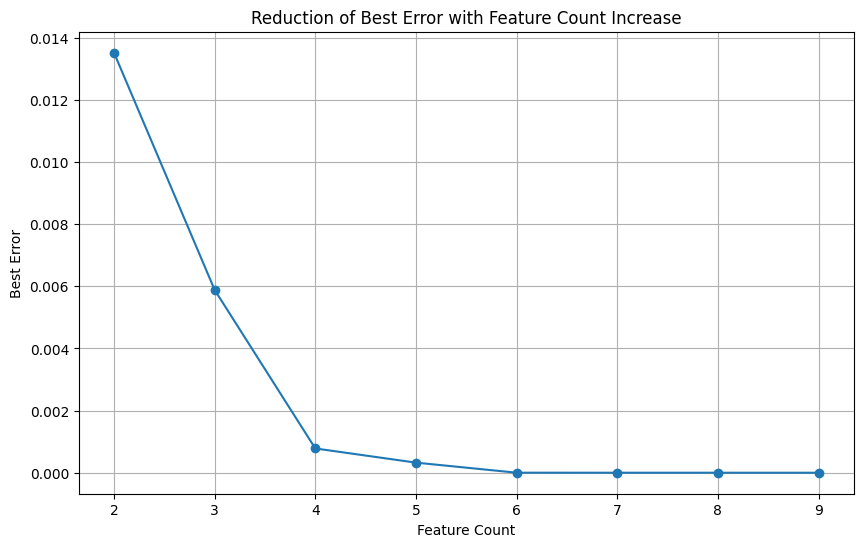

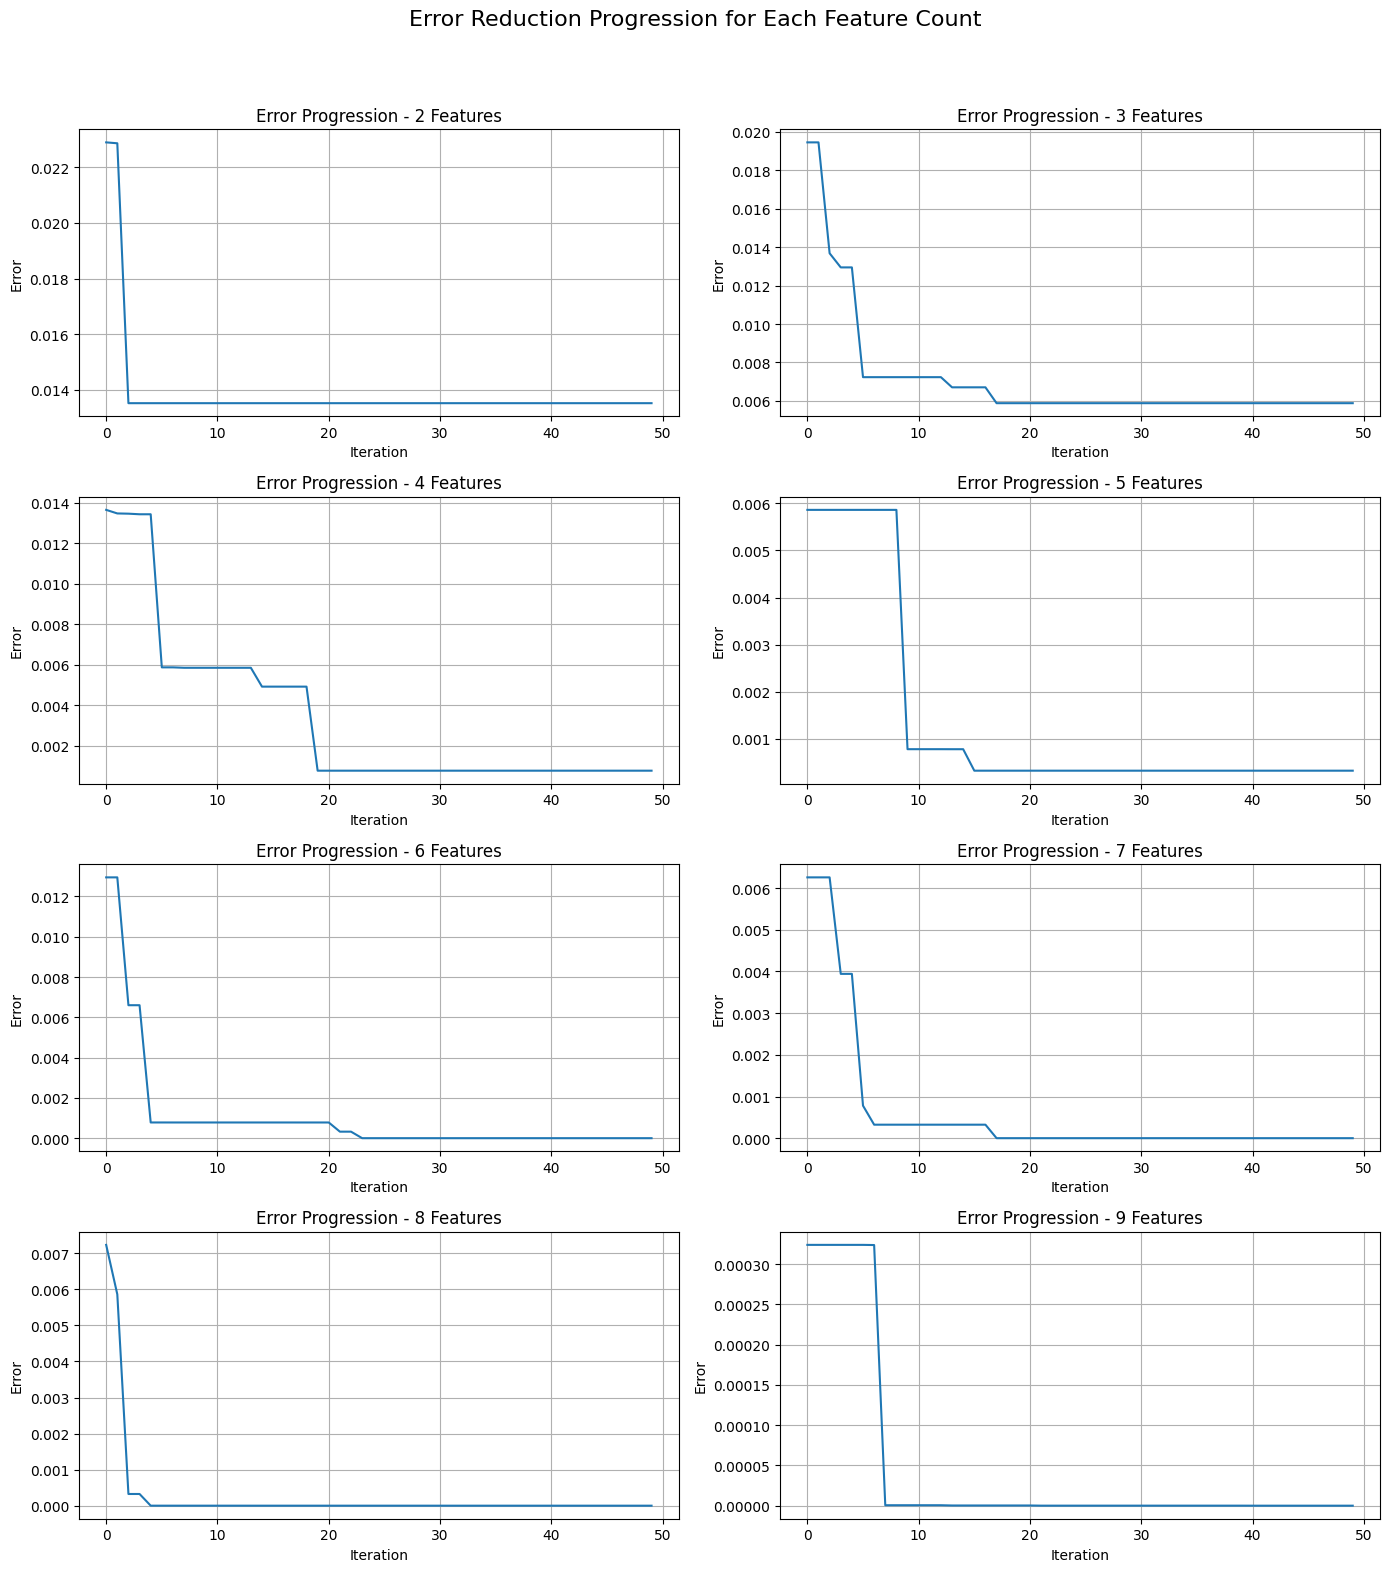

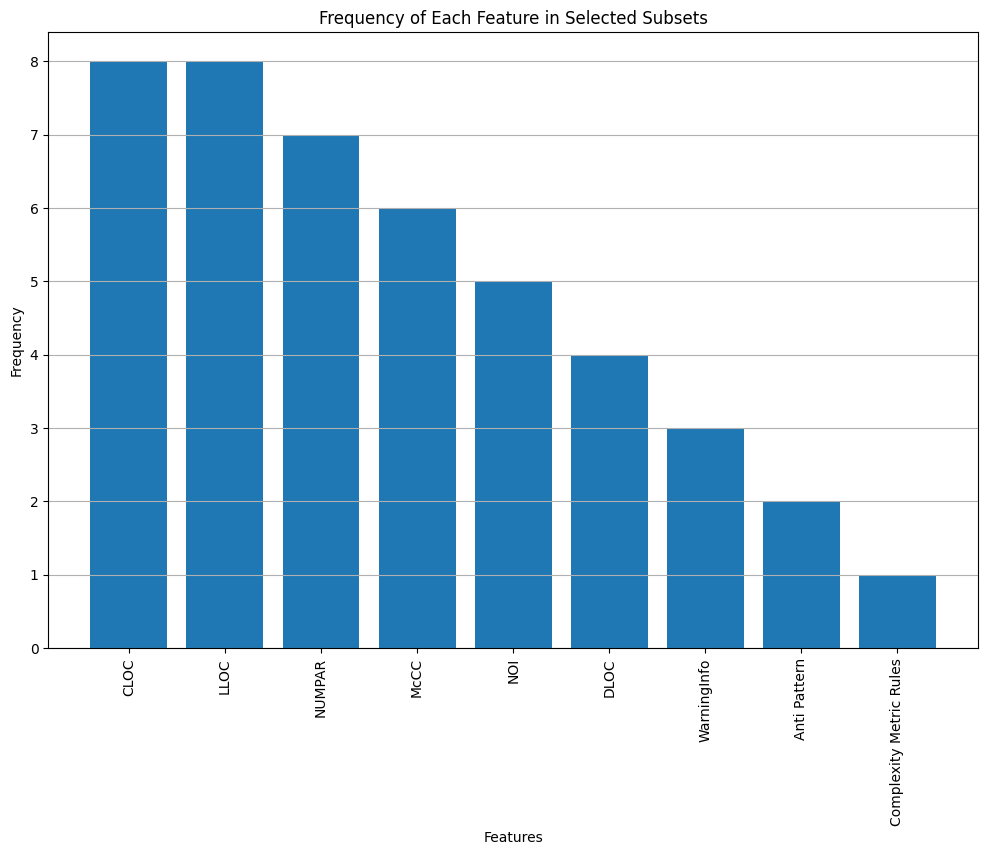

In [ ]:
analyze_file('../../outputs/log/abc_reduced.log', 'lm-sys_FastChat-Method.csv')

[('LOC', 614), ('TLOC', 614), ('TLLOC', 580), ('LLOC', 538), ('TNOS', 475), ('TCLOC', 452), ('CLOC', 414), ('NOS', 399), ('DLOC', 336), ('NUMPAR', 334), ('McCC', 257), ('NOI', 229), ('WarningInfo', 156), ('Size Metric Rules', 135), ('Anti Pattern', 131), ('Complexity Metric Rules', 80), ('Coupling Metric Rules', 33), ('WarningCritical', 21), ('CD', 21), ('TCD', 21), ('NLE', 20), ('NII', 20), ('WarningMinor', 19), ('WarningBlocker', 19), ('NL', 18), ('Documentation Metric Rules', 15), ('WarningMajor', 11)]


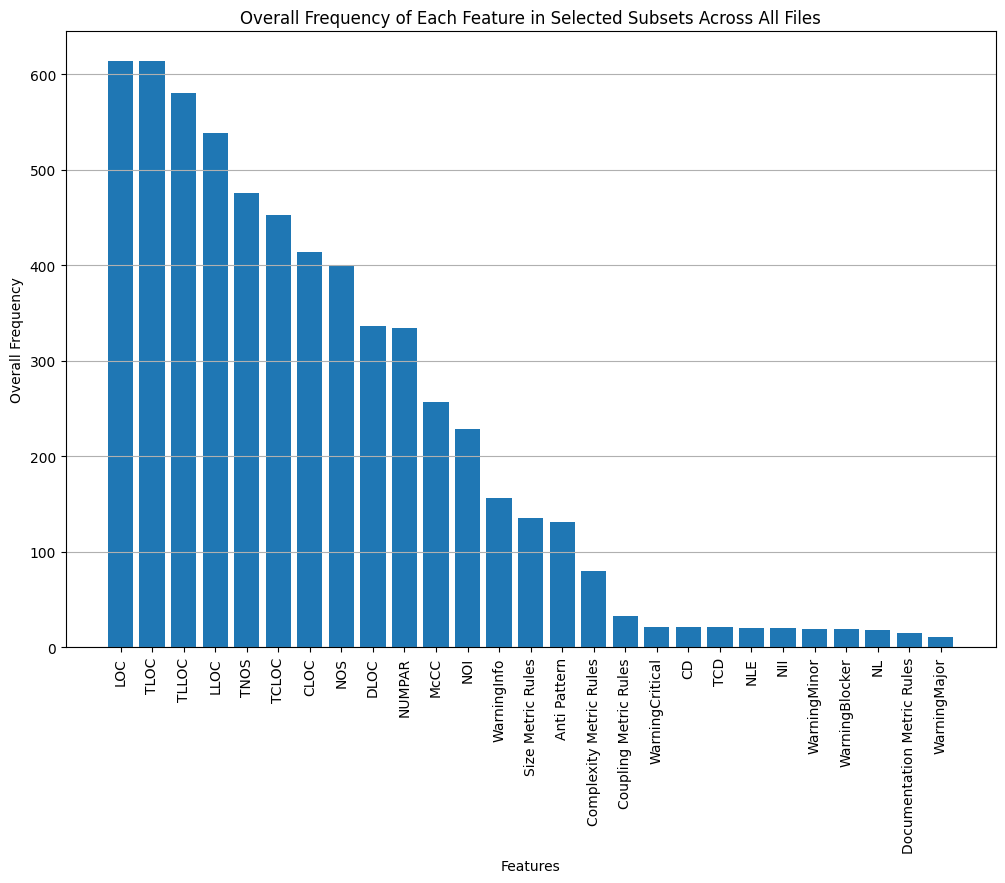

In [6]:
def plot_overall_feature_frequency_all(log_name):
    overall_selected_features = []

    with open(log_name, 'r') as file:
        for line in file:
            match = re.search(r"Selected subset: \[(.*?)\]", line)
            if match:
                features = re.findall(r"'(.*?)'", match.group(1))
                overall_selected_features.extend(features)

    feature_counter = Counter(overall_selected_features)
    sorted_features = feature_counter.most_common()
    print(sorted_features)
    features, counts = zip(*sorted_features)

    plt.figure(figsize=(12, 8))
    plt.bar(features, counts)
    plt.xlabel("Features")
    plt.ylabel("Overall Frequency")
    plt.title("Overall Frequency of Each Feature in Selected Subsets Across All Files")
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()

log_name = r'outputs\log\abc_kaggle.log'
plot_overall_feature_frequency_all(log_name)

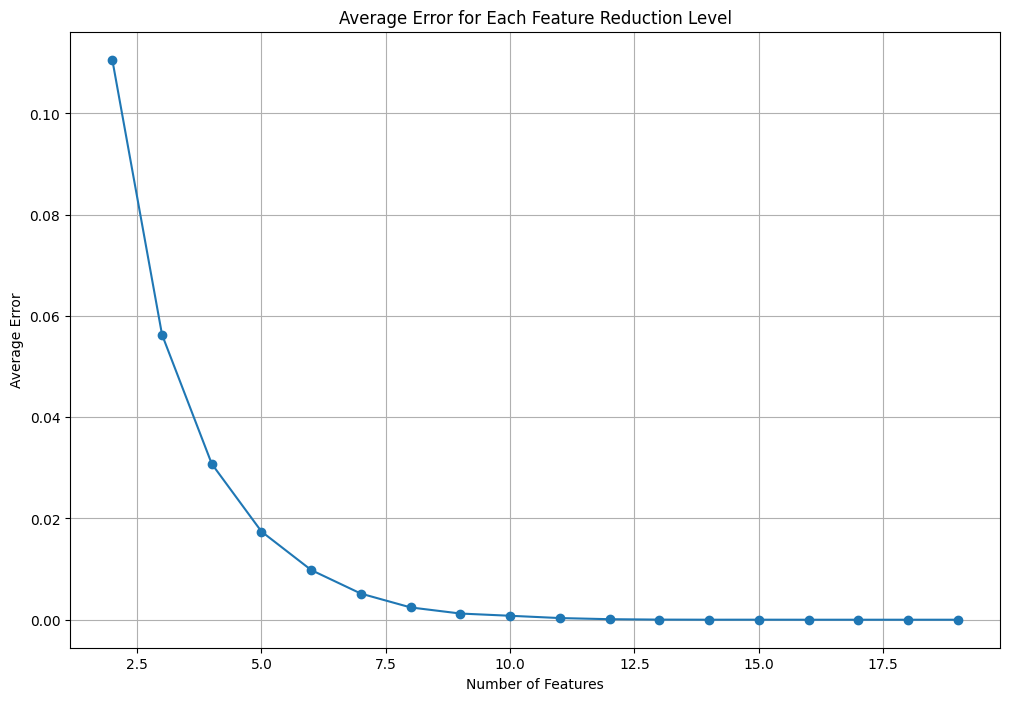

In [ ]:
from collections import defaultdict

def parse_log_and_calculate_errors(log_name):
    feature_errors = defaultdict(list)
    with open(log_name, 'r') as f:
        current_feature_count = None
        for line in f:
            reduction_match = re.match(r"Reduction to (\d+) features.", line)
            if reduction_match:
                current_feature_count = int(reduction_match.group(1))
            error_match = re.match(r"Best error: ([\d.e+-]+).", line)
            if error_match and current_feature_count is not None:
                error = float(error_match.group(1))
                feature_errors[current_feature_count].append(error)
                current_feature_count = None
    avg_errors = {count: sum(errors) / len(errors) for count, errors in feature_errors.items()}
    return avg_errors

def plot_average_error(avg_errors):
    feature_counts = sorted(avg_errors.keys())
    avg_error_values = [avg_errors[count] for count in feature_counts]
    plt.figure(figsize=(12, 8))
    plt.plot(feature_counts, avg_error_values, marker='o', linestyle='-')
    plt.xlabel("Number of Features")
    plt.ylabel("Average Error")
    plt.title("Average Error for Each Feature Reduction Level")
    plt.grid(True)
    plt.show()

log_name = r'..\..\outputs\log\abc_kaggle.log'
avg_errors = parse_log_and_calculate_errors(log_name)
plot_average_error(avg_errors)

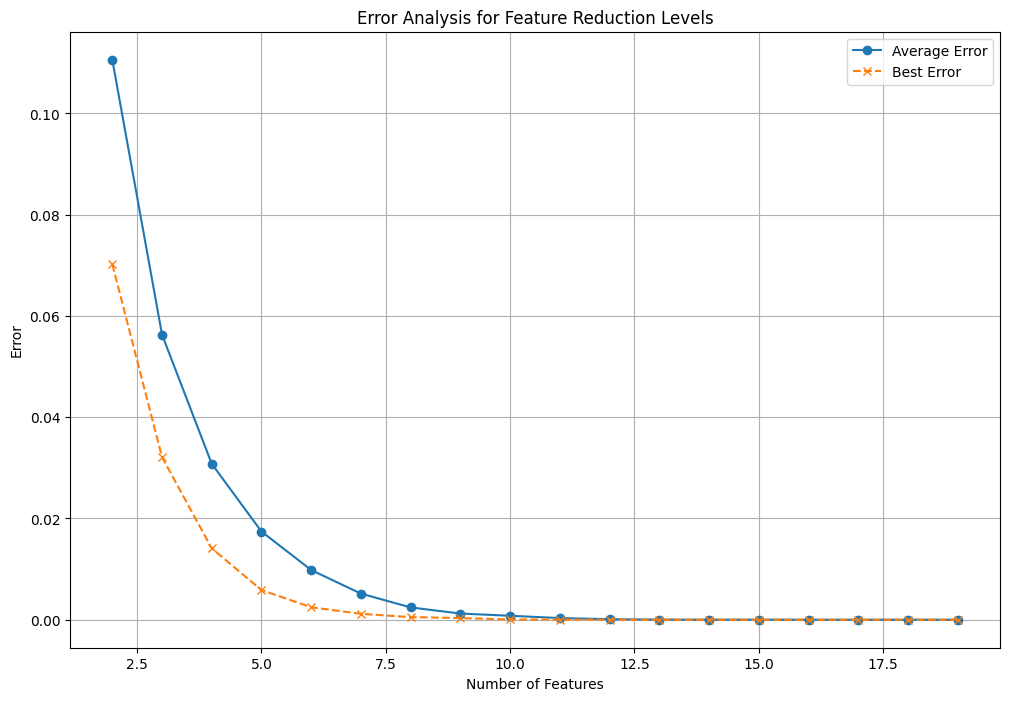

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
import re

def parse_log_and_calculate_errors(log_name):
    feature_errors = defaultdict(list)
    best_errors = {}
    with open(log_name, 'r') as f:
        current_feature_count = None
        for line in f:
            reduction_match = re.match(r"Reduction to (\d+) features.", line)
            if reduction_match:
                current_feature_count = int(reduction_match.group(1))
            error_match = re.match(r"Best error: ([\d.e+-]+).", line)
            if error_match and current_feature_count is not None:
                error = float(error_match.group(1))
                feature_errors[current_feature_count].append(error)
                # Track the minimum (best) error for each feature count
                if current_feature_count not in best_errors or error < best_errors[current_feature_count]:
                    best_errors[current_feature_count] = error
                current_feature_count = None
    avg_errors = {count: sum(errors) / len(errors) for count, errors in feature_errors.items()}
    return avg_errors, best_errors

def plot_errors(avg_errors, best_errors):
    feature_counts = sorted(avg_errors.keys())
    avg_error_values = [avg_errors[count] for count in feature_counts]
    best_error_values = [best_errors[count] for count in feature_counts]
    
    plt.figure(figsize=(12, 8))
    plt.plot(feature_counts, avg_error_values, marker='o', linestyle='-', label="Average Error")
    plt.plot(feature_counts, best_error_values, marker='x', linestyle='--', label="Best Error")
    plt.xlabel("Number of Features")
    plt.ylabel("Error")
    plt.title("Error Analysis for Feature Reduction Levels")
    plt.legend()
    plt.grid(True)
    plt.show()

avg_errors, best_errors = parse_log_and_calculate_errors(log_name)
plot_errors(avg_errors, best_errors)